# GEONE - Pluri-Gaussian simulation (PGS)

Pluri-Gaussian simulation (PGS) in 1D, 2D and 3D.

A pluri-Gaussian simulation $Z(x)$ is defined as $Z(x) = f(T_1(x), T_2(x))$ where

- $T_1, T_2$ are two independent multi-Gaussian random fields (latent fields) defined over a same grid
- $f$ is a function defining the final value (categorical) in the field $Z$; it is given as a "flag"

## Import what is required

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import pyvista as pv

# import package 'geone'
import geone as gn

In [2]:
# Show version of python and version of geone
import sys 
print(sys.version_info)
print('geone version: ' + gn.__version__)

sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
geone version: 1.2.17


In [3]:
pv.set_jupyter_backend('static') # to get static plots within the jupyter notebook

## Function `geone.pgs.pluriGaussianSim`

This function allows to generate realizations in 1D, 2D and 3D (see examples below). Conditional and unconditional simulations can be done. For conditional simulation, a kind of Metropolis-Hasting algorithm is used (see help of the function); if conditioning fails, it is possible to get less realizations than the specified number (warning is displayed depending on the `verbose` keyword argument).

In full output mode (keyword argument `full_output=True` (default)), in addition to the resulting $Z$ fields, are retrieved in output: the two latent fields for every realization as well as a list of 1d-array (one per realization) containing the number of conditioning locations honoured at each iteration of the Metropolis-Hasting algorithm.

## Example : conditional 1D PGS

In [4]:
# Categories
ncat = 4
categVal = np.array([1, 2, 3, 4])

# Parameters for display (used further)
categCol = ['lightblue', 'darkgreen', 'orange', 'brown']
im_T1_display={'cmap':'terrain'}
im_T2_display={'cmap':'terrain'}
im_Z_display={'categ':True, 'categVal':categVal, 'categCol':categCol}

In [5]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 220, 1,   1    # number of cells
sx, sy, sz = 0.5, 1.0, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T1, T2 (latent fields)
# -------------------------------------------
r_T1 = 15.0
w_T1 = 1.0
nu_T1 = 1.5
cov_model_T1 = gn.covModel.CovModel1D(elem=[
    ('matern', {'w':w_T1, 'r':gn.covModel.cov_matern_get_r_param(nu_T1, r_T1), 'nu':nu_T1}),
    ], name='cov_model_T1')

r_T2 = 30.0
w_T2 = 1.0
nu_T2 = 1.5
cov_model_T2 = gn.covModel.CovModel1D(elem=[
    ('matern', {'w':w_T2, 'r':gn.covModel.cov_matern_get_r_param(nu_T2, r_T2), 'nu':nu_T2}),
    ], name='cov_model_T2')

# Mean of T1, T2
mean_T1 = 0.0
mean_T2 = 0.0

# Flag definition
# ---------------
def flag_value(x, y):
    v0, v1, v2, v3 = categVal
    x1 = x < -0.5
    y1 = y < -1.
    y2 = y < 1.
    return v0 * x1 + (1-x1) * (v1 * y1 + (1-y1) * (v2*y2 + v3*(1-y2)))

# Pluri-Gaussian simulation: Z = flag_value(T1, T2)
# -------------------------------------------------

# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
x = np.array([17.25, 27.25, 54.25, 66.25, 75.25])
v = np.array([1, 1, 2, 4, 4])
v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)
# or:
#v_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)

# Number of realizations and seed
nreal = 3
seed_sim = 1345
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T1, T2, n_cond_ok = gn.pgs.pluriGaussianSim(
    cov_model_T1, cov_model_T2, flag_value, nx, sx, ox,
    x=x, v=v,
    algo_T1='fft', params_T1={'mean':mean_T1},
    algo_T2='fft', params_T2={'mean':mean_T2, 'rangeFactorForExtensionMin':2},
    # algo_T1='classic', params_T1={'mean':mean_T1, 'nneighborMax':24}, # alternative algo for T1
    # algo_T2='classic', params_T1={'mean':mean_T2, 'nneighborMax':24}, # alternative algo for T2
    nreal=nreal,
    accept_init=0.75, accept_pow=2.0,
    mh_iter_min=100, mh_iter_max=200,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1}')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T1 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T1.shape[0], val=T1)
im_T2 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T2.shape[0], val=T2)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx, 0., 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

pluriGaussianSim: simulation 1 of 3...
   ... sim 1 of 3: MH iter 1 of 100,  200...
   ... sim 1 of 3: MH iter 2 of 100,  200...
   ... sim 1 of 3: MH iter 3 of 100,  200...
   ... sim 1 of 3: MH iter 4 of 100,  200...
   ... sim 1 of 3: MH iter 5 of 100,  200...
   ... sim 1 of 3: MH iter 6 of 100,  200...
   ... sim 1 of 3: MH iter 7 of 100,  200...
   ... sim 1 of 3: MH iter 8 of 100,  200...
   ... sim 1 of 3: MH iter 9 of 100,  200...
   ... sim 1 of 3: MH iter 10 of 100,  200...
   ... sim 1 of 3: MH iter 11 of 100,  200...
   ... sim 1 of 3: MH iter 12 of 100,  200...
   ... sim 1 of 3: MH iter 13 of 100,  200...
   ... sim 1 of 3: MH iter 14 of 100,  200...
   ... sim 1 of 3: MH iter 15 of 100,  200...
   ... sim 1 of 3: MH iter 16 of 100,  200...
   ... sim 1 of 3: MH iter 17 of 100,  200...
   ... sim 1 of 3: MH iter 18 of 100,  200...
   ... sim 1 of 3: MH iter 19 of 100,  200...
   ... sim 1 of 3: MH iter 20 of 100,  200...
   ... sim 1 of 3: MH iter 21 of 100,  200...
   .

/home/julien/anaconda3/envs/py311/lib/python3.11/site-packages/geone/covModel.py:380: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


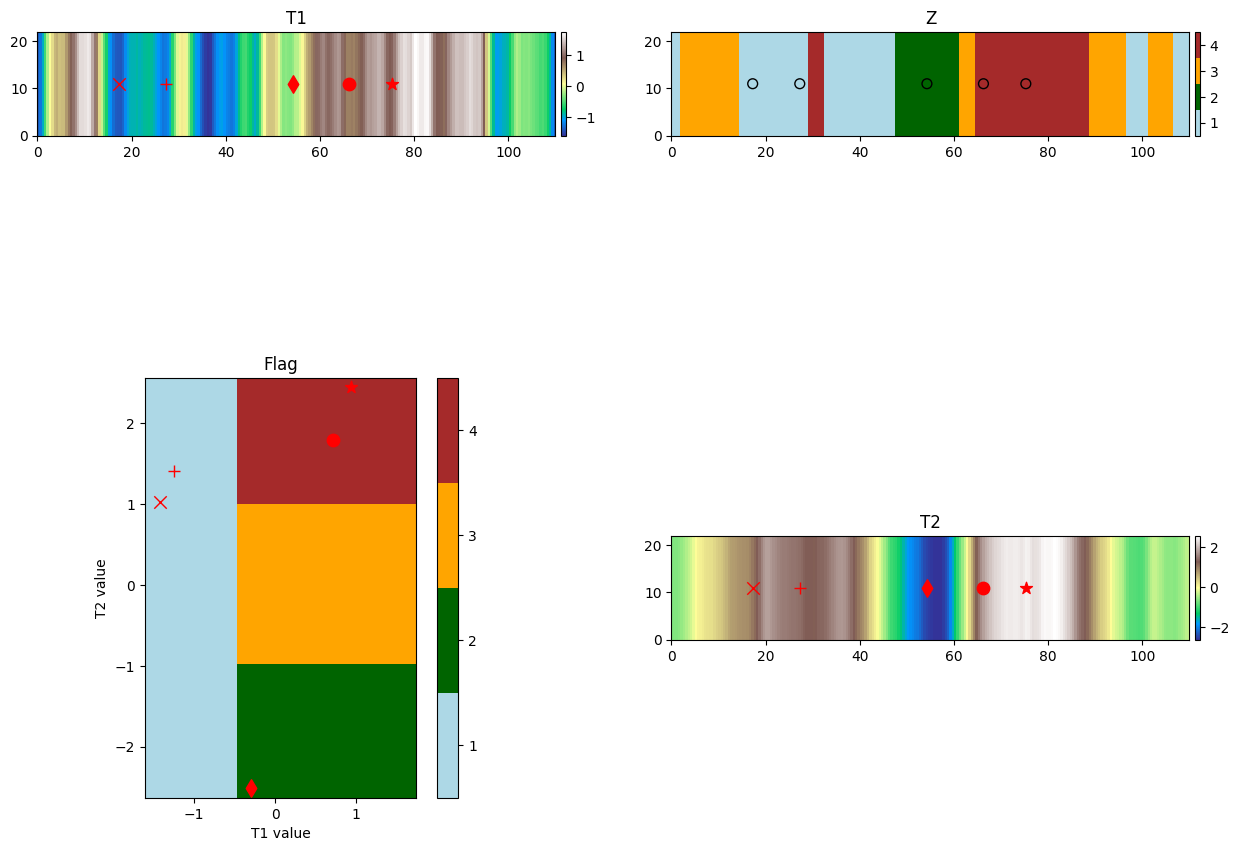

In [6]:
# Set spacing in y direction (1 cell) to visualize images using gn.imgplot.drawImage2D
im_T1.sy = .2 * im_T1.sx*im_T1.nx 
im_T2.sy = .2 * im_T2.sx*im_T2.nx 
im_Z.sy = .2 * im_Z.sx*im_Z.nx 

# Plot results 
# ------------
ireal = 0 # realization to plot

# Fill image for flag
# ------------------
fnx, fny, fnz = 50, 50, 1
fox, foy, foz = im_T1.val[ireal].min(), im_T2.val[ireal].min(), 0.0
fsx, fsy, fsz = (im_T1.val[ireal].max() - fox)/fnx, (im_T2.val[ireal].max() - foy)/fny, 1.0
fx = fox + (np.arange(fnx)+0.5)*fsx 
fy = foy + (np.arange(fny)+0.5)*fsy 
yy, xx = np.meshgrid (fy, fx, indexing='ij')
fv = flag_value(xx, yy)
im_flag = gn.img.Img(nx=fnx, ny=fny, nz=fnz, sx=fsx, sy=fsy, sz=fsz, ox=fox, oy=foy, oz=foz, nv=1, val=fv)

# Plot
# ----
marker_loc = ['x', '+', 'd', 'o', '*']

plt.subplots(2,2, figsize=(15, 12))

# T1
plt.subplot(2,2,1)
gn.imgplot.drawImage2D(im_T1, iv=ireal, **im_T1_display)
# Add conditioning location
if x is not None:
    yc = im_T1.oy+0.5*im_T1.sy
    # plt.plot(x, yc*np.ones_like(x), 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i], yc, marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

plt.title('T1')

# Z
plt.subplot(2,2,2)
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    yc = im_Z.oy+0.5*im_Z.sy
    plt.scatter(x, yc*np.ones_like(x), marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)

plt.title('Z')

# flag
plt.subplot(2,2,3)
gn.imgplot.drawImage2D(im_flag, **im_Z_display)
plt.xlabel('T1 value')
plt.ylabel('T2 value')
plt.title(f'Flag')

# Add conditioning location
if x is not None:
    indx, indy, indz = gn.img.pointToGridIndex(x, np.zeros_like(x), np.zeros_like(x), sx, sy, sz, ox, oy, oz)
    y1 = np.array([im_T1.val[ireal, iz, iy, ix] for ix, iy, iz in zip(indx, indy, indz)])
    y2 = np.array([im_T2.val[ireal, iz, iy, ix] for ix, iy, iz in zip(indx, indy, indz)])
    for i in range(len(y1)):
        plt.scatter(y1[i], y2[i], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

# T2
plt.subplot(2,2,4)
gn.imgplot.drawImage2D(im_T2, iv=ireal, **im_T2_display)
# Add conditioning location
if x is not None:
    yc = im_T2.oy+0.5*im_T2.sy
    # plt.plot(x, yc*np.ones_like(x), 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i], yc, marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

plt.title('T2')

plt.show()

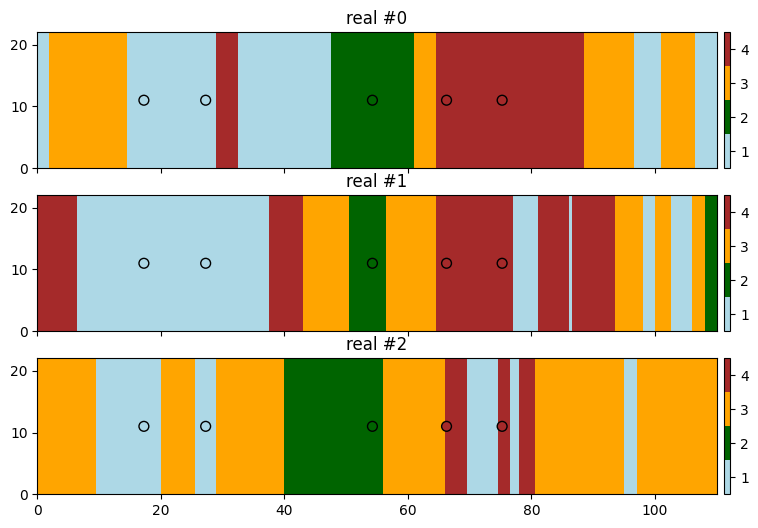

In [7]:
# Plot 3 realizations of Z
plt.subplots(3,1, sharex=True, sharey=True, figsize=(15,6))
plt.subplot(3,1,1)
for j in range(3):
    plt.subplot(3,1,j+1)
    gn.imgplot.drawImage2D(im_Z, iv=j, **im_Z_display)
    if x is not None:
        yc = im_Z.oy+0.5*im_Z.sy
        plt.scatter(x, yc*np.ones_like(x), marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'real #{j}')

plt.show()

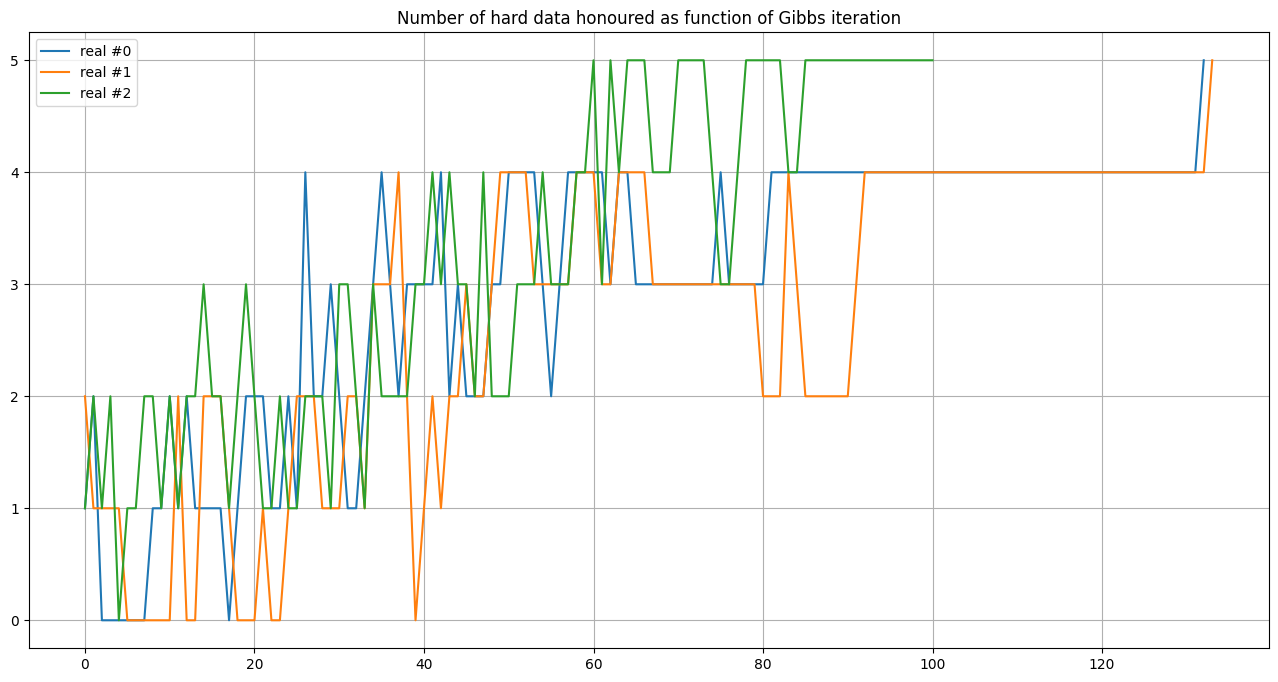

In [8]:
# Plot number of conditioning data honoured as function of iteration (Metropolis-Hasting / Gibbs sampler)
if x is not None:
    plt.figure(figsize=(16,8))
    for j in range(3):
        plt.plot(n_cond_ok[j], label=f'real #{j}')

    plt.grid()
    plt.legend()
    plt.title('Number of hard data honoured as function of Gibbs iteration')
    plt.show()

### 100 realizations (same setup)

In [9]:
# Number of realizations and seed
nreal = 100
seed_sim = 1345

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.pgs.pluriGaussianSim(
    cov_model_T1, cov_model_T2, flag_value, nx, sx, ox,
    x=x, v=v,
    algo_T1='fft', params_T1={'mean':mean_T1},
    algo_T2='fft', params_T2={'mean':mean_T2, 'rangeFactorForExtensionMin':2},
    # algo_T1='classic', params_T1={'mean':mean_T1, 'nneighborMax':24}, # alternative algo for T1
    # algo_T2='classic', params_T1={'mean':mean_T2, 'nneighborMax':24}, # alternative algo for T2
    nreal=nreal,
    accept_init=0.75, accept_pow=2.0,
    mh_iter_min=100, mh_iter_max=200,
    full_output=False,
    verbose=2,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1}')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx, 0., 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

pluriGaussianSim: simulation 1 of 100...
pluriGaussianSim: simulation 2 of 100...
pluriGaussianSim: simulation 3 of 100...
pluriGaussianSim: simulation 4 of 100...
pluriGaussianSim: simulation 5 of 100...
pluriGaussianSim: simulation 6 of 100...
pluriGaussianSim: simulation 7 of 100...
pluriGaussianSim: simulation 8 of 100...
pluriGaussianSim: simulation 9 of 100...
pluriGaussianSim: simulation 10 of 100...
pluriGaussianSim: simulation 11 of 100...
pluriGaussianSim: simulation 12 of 100...
pluriGaussianSim: simulation 13 of 100...
pluriGaussianSim: simulation 14 of 100...
pluriGaussianSim: simulation 15 of 100...
pluriGaussianSim: simulation 16 of 100...
pluriGaussianSim: simulation 17 of 100...
pluriGaussianSim: simulation 18 of 100...
pluriGaussianSim: simulation 19 of 100...
pluriGaussianSim: simulation 20 of 100...
pluriGaussianSim: simulation 21 of 100...
pluriGaussianSim: simulation 22 of 100...
pluriGaussianSim: simulation 23 of 100...
pluriGaussianSim: simulation 24 of 100...
p

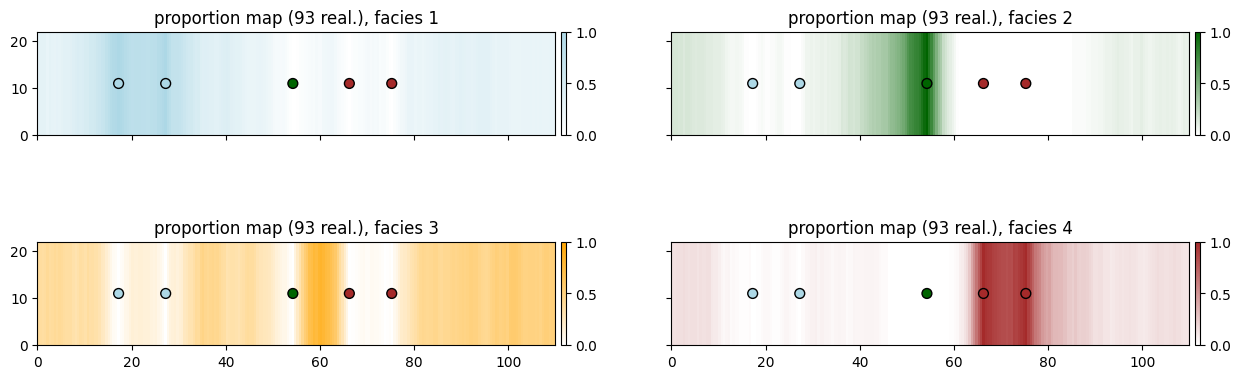

In [10]:
# Set spacing in y direction (1 cell) to visualize images using gn.imgplot.drawImage2D
im_Z.sy = .2 * im_Z.sx*im_Z.nx 

# Statistics (proportion map)
# ---------------------------
im_Z_stats = gn.img.imageCategProp(im_Z, categVal)

prop_col = categCol # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Plot
# ----
plt.subplots(2,2, sharex=True, sharey=True, figsize=(15,5))
plt.subplot(2,2,1)
for j in range(4):
    plt.subplot(2,2,j+1)
    gn.imgplot.drawImage2D(im_Z_stats, iv=j, cmap=cmap[j], vmin=0, vmax=1)
    if x is not None:
        yc = im_Z.oy+0.5*im_Z.sy
        plt.scatter(x, yc*np.ones_like(x), marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'proportion map ({im_Z.nv} real.), facies {categVal[j]}')

plt.show()

## Example : conditional 2D PGS

In [11]:
# Categories
ncat = 4
categVal = np.array([1, 2, 3, 4])

# Parameters for display (used further)
categCol = ['lightblue', 'darkgreen', 'orange', 'brown']
im_T1_display={'cmap':'terrain'}
im_T2_display={'cmap':'terrain'}
im_Z_display={'categ':True, 'categVal':categVal, 'categCol':categCol}

In [12]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 220, 210, 1    # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T1, T2 (latent fields)
# -------------------------------------
r_T1 = 1.0*np.array([25.0, 25.0])
w_T1 = 1.0
nu_T1 = 1.5
cov_model_T1 = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T1, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T1, r) for r in r_T1]), 'nu':nu_T1}),
    ], alpha=0.0, name='cov_model_T1')

r_T2 = 1.0*np.array([30.0, 10.0])
w_T2 = 1.0
nu_T2 = 1.5
cov_model_T2 = gn.covModel.CovModel2D(elem=[
    ('matern', {'w':w_T2, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T2, r) for r in r_T2]), 'nu':nu_T2}),
    ], alpha=-45.0, name='cov_model_T2')

# Mean of T1, T2
mean_T1 = 0.0
mean_T2 = 0.0

# Flag definition
# ---------------
def flag_value(x, y):
    v0, v1, v2, v3 = categVal
    x1 = x < -0.5
    y1 = y < -1.
    y2 = y < 1.
    return v0 * x1 + (1-x1) * (v1 * y1 + (1-y1) * (v2*y2 + v3*(1-y2)))

# Pluri-Gaussian simulation: Z = flag_value(T1, T2)
# -------------------------------------------------

# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
x = np.array([[37.25, 25.25],
              [67.25, 24.25],
              [50.25, 52.25],
              [36.25, 80.25],
              [66.25, 81.25]])
v = np.array([1, 1, 2, 4, 4])
v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)
# or:
#v_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)
##
##
#np.random.seed(123)
#nhd = 30
#x = np.array((ox + np.random.random(nhd)*nx*sx, oy + np.random.random(nhd)*ny*sy)).T
#v = np.random.choice(categVal, replace=True, size=nhd)
#v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)

# Number of realizations and seed
nreal = 3
seed_sim = 1345
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T1, T2, n_cond_ok = gn.pgs.pluriGaussianSim(
    cov_model_T1, cov_model_T2, flag_value, (nx, ny), (sx, sy), (ox, oy),
    x=x, v=v,
    algo_T1='fft', params_T1={'mean':mean_T1},
    algo_T2='fft', params_T2={'mean':mean_T2, 'rangeFactorForExtensionMin':2},
    # algo_T1='classic', params_T1={'mean':mean_T1, 'nneighborMax':24}, # alternative algo for T1
    # algo_T2='classic', params_T1={'mean':mean_T2, 'nneighborMax':24}, # alternative algo for T2
    nreal=nreal,
    accept_init=0.75, accept_pow=2.0,
    mh_iter_min=100, mh_iter_max=200,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1}')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T1 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T1.shape[0], val=T1)
im_T2 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T2.shape[0], val=T2)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

/home/julien/anaconda3/envs/py311/lib/python3.11/site-packages/geone/covModel.py:380: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


pluriGaussianSim: simulation 1 of 3...
   ... sim 1 of 3: MH iter 1 of 100,  200...
   ... sim 1 of 3: MH iter 2 of 100,  200...
   ... sim 1 of 3: MH iter 3 of 100,  200...
   ... sim 1 of 3: MH iter 4 of 100,  200...
   ... sim 1 of 3: MH iter 5 of 100,  200...
   ... sim 1 of 3: MH iter 6 of 100,  200...
   ... sim 1 of 3: MH iter 7 of 100,  200...
   ... sim 1 of 3: MH iter 8 of 100,  200...
   ... sim 1 of 3: MH iter 9 of 100,  200...
   ... sim 1 of 3: MH iter 10 of 100,  200...
   ... sim 1 of 3: MH iter 11 of 100,  200...
   ... sim 1 of 3: MH iter 12 of 100,  200...
   ... sim 1 of 3: MH iter 13 of 100,  200...
   ... sim 1 of 3: MH iter 14 of 100,  200...
   ... sim 1 of 3: MH iter 15 of 100,  200...
   ... sim 1 of 3: MH iter 16 of 100,  200...
   ... sim 1 of 3: MH iter 17 of 100,  200...
   ... sim 1 of 3: MH iter 18 of 100,  200...
   ... sim 1 of 3: MH iter 19 of 100,  200...
   ... sim 1 of 3: MH iter 20 of 100,  200...
   ... sim 1 of 3: MH iter 21 of 100,  200...
   .

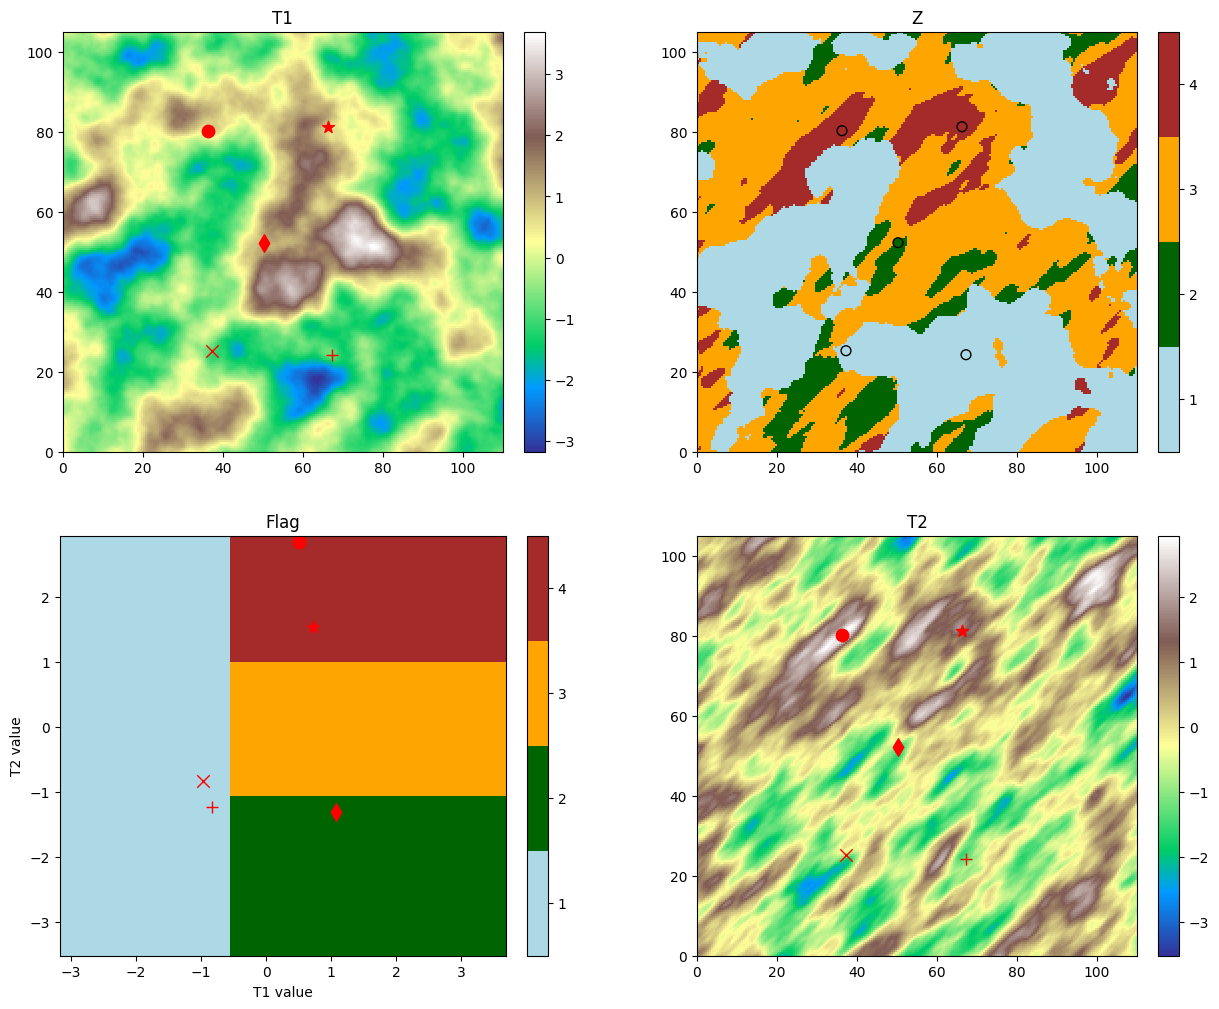

In [13]:
# Plot results 
# ------------
ireal = 0 # realization to plot

# Fill image for flag
# ------------------
fnx, fny, fnz = 50, 50, 1
fox, foy, foz = im_T1.val[ireal].min(), im_T2.val[ireal].min(), 0.0
fsx, fsy, fsz = (im_T1.val[ireal].max() - fox)/fnx, (im_T2.val[ireal].max() - foy)/fny, 1.0
fx = fox + (np.arange(fnx)+0.5)*fsx 
fy = foy + (np.arange(fny)+0.5)*fsy 
yy, xx = np.meshgrid (fy, fx, indexing='ij')
fv = flag_value(xx, yy)
im_flag = gn.img.Img(nx=fnx, ny=fny, nz=fnz, sx=fsx, sy=fsy, sz=fsz, ox=fox, oy=foy, oz=foz, nv=1, val=fv)

# Plot
# ----
marker_loc = ['x', '+', 'd', 'o', '*']

plt.subplots(2,2, figsize=(15, 12))

# T1
plt.subplot(2,2,1)
gn.imgplot.drawImage2D(im_T1, iv=ireal, **im_T1_display)
# Add conditioning location
if x is not None:
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

plt.title('T1')

# Z
plt.subplot(2,2,2)
gn.imgplot.drawImage2D(im_Z, iv=ireal, **im_Z_display)
# Add conditioning data
if x is not None:
    plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)

plt.title('Z')

# flag
plt.subplot(2,2,3)
gn.imgplot.drawImage2D(im_flag, **im_Z_display)
plt.xlabel('T1 value')
plt.ylabel('T2 value')
plt.title(f'Flag')

# Add conditioning location
if x is not None:
    indx, indy, indz = gn.img.pointToGridIndex(x[:,0], x[:,1], np.zeros_like(x[:,0]), sx, sy, sz, ox, oy, oz)
    y1 = np.array([im_T1.val[ireal, iz, iy, ix] for ix, iy, iz in zip(indx, indy, indz)])
    y2 = np.array([im_T2.val[ireal, iz, iy, ix] for ix, iy, iz in zip(indx, indy, indz)])
    for i in range(len(y1)):
        plt.scatter(y1[i], y2[i], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

# T2
plt.subplot(2,2,4)
gn.imgplot.drawImage2D(im_T2, iv=ireal, **im_T2_display)
# Add conditioning location
if x is not None:
    # plt.plot(x[:,0], x[:,1], 'rx', markersize=20)
    for i in range(len(x)): 
        plt.scatter(x[i,0], x[i,1], marker=marker_loc[i%len(marker_loc)], color='red', s=80, linewidths=1)

plt.title('T2')

plt.show()

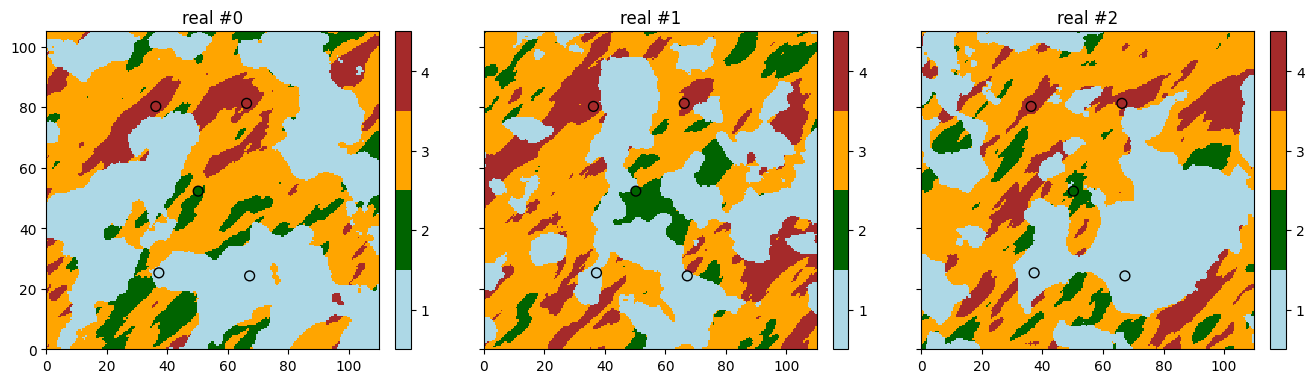

In [14]:
# Plot 3 realizations of Z
plt.subplots(1,3, sharex=True, sharey=True, figsize=(16,8))
plt.subplot(1,3,1)
for j in range(3):
    plt.subplot(1,3,j+1)
    gn.imgplot.drawImage2D(im_Z, iv=j, **im_Z_display)
    if x is not None:
        plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'real #{j}')

plt.show()

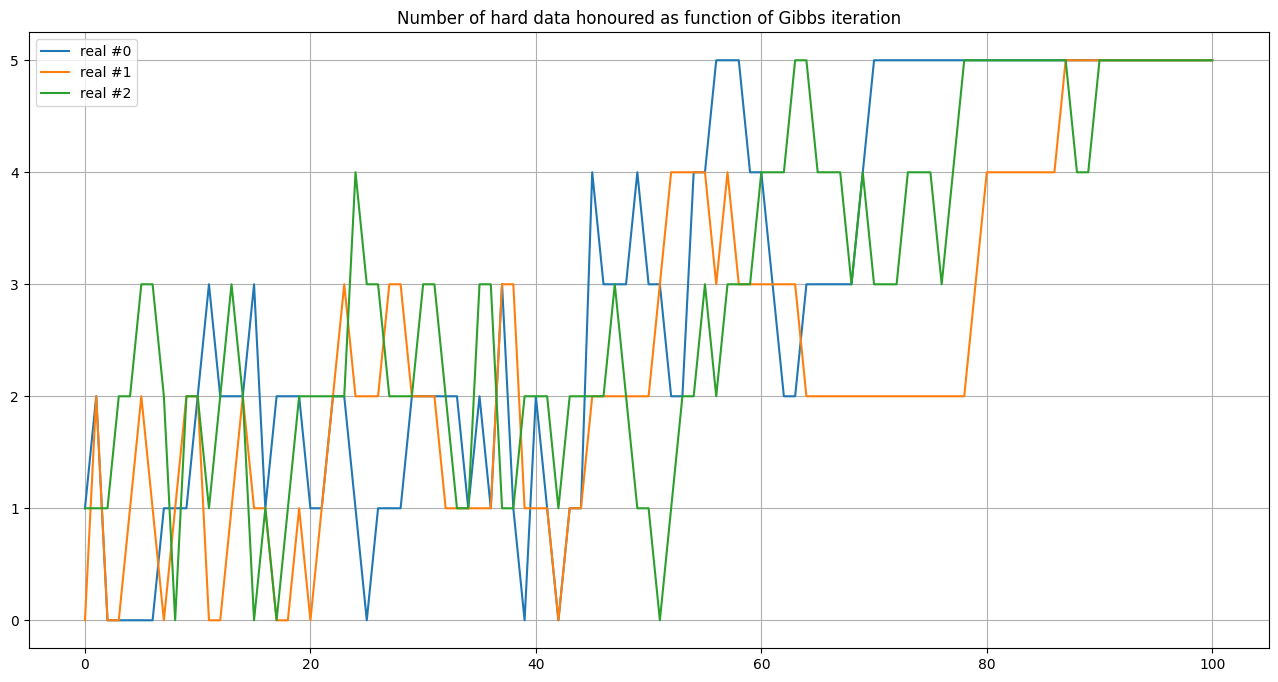

In [15]:
# Plot number of conditioning data honoured as function of iteration (Metropolis-Hasting / Gibbs sampler)
if x is not None:
    plt.figure(figsize=(16,8))
    for j in range(3):
        plt.plot(n_cond_ok[j], label=f'real #{j}')

    plt.grid()
    plt.legend()
    plt.title('Number of hard data honoured as function of Gibbs iteration')
    plt.show()

### 100 realizations (same setup)

In [16]:
# Number of realizations and seed
nreal = 100
seed_sim = 1345

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.pgs.pluriGaussianSim(
    cov_model_T1, cov_model_T2, flag_value, (nx, ny), (sx, sy), (ox, oy),
    x=x, v=v,
    algo_T1='fft', params_T1={'mean':mean_T1},
    algo_T2='fft', params_T2={'mean':mean_T2, 'rangeFactorForExtensionMin':2},
    # algo_T1='classic', params_T1={'mean':mean_T1, 'nneighborMax':24}, # alternative algo for T1
    # algo_T2='classic', params_T1={'mean':mean_T2, 'nneighborMax':24}, # alternative algo for T2
    nreal=nreal,
    accept_init=0.75, accept_pow=2.0,
    mh_iter_min=100, mh_iter_max=200,
    full_output=False,
    verbose=2,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1}')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], 0., sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

pluriGaussianSim: simulation 1 of 100...
pluriGaussianSim: simulation 2 of 100...
pluriGaussianSim: simulation 3 of 100...
pluriGaussianSim: simulation 4 of 100...
pluriGaussianSim: simulation 5 of 100...
pluriGaussianSim: simulation 6 of 100...
pluriGaussianSim: simulation 7 of 100...
pluriGaussianSim: simulation 8 of 100...
pluriGaussianSim: simulation 9 of 100...
pluriGaussianSim: simulation 10 of 100...
pluriGaussianSim: simulation 11 of 100...
pluriGaussianSim: simulation 12 of 100...
pluriGaussianSim: simulation 13 of 100...
pluriGaussianSim: simulation 14 of 100...
pluriGaussianSim: simulation 15 of 100...
pluriGaussianSim: simulation 16 of 100...
pluriGaussianSim: simulation 17 of 100...
pluriGaussianSim: simulation 18 of 100...
pluriGaussianSim: simulation 19 of 100...
pluriGaussianSim: simulation 20 of 100...
pluriGaussianSim: simulation 21 of 100...
pluriGaussianSim: simulation 22 of 100...
pluriGaussianSim: simulation 23 of 100...
pluriGaussianSim: simulation 24 of 100...
p

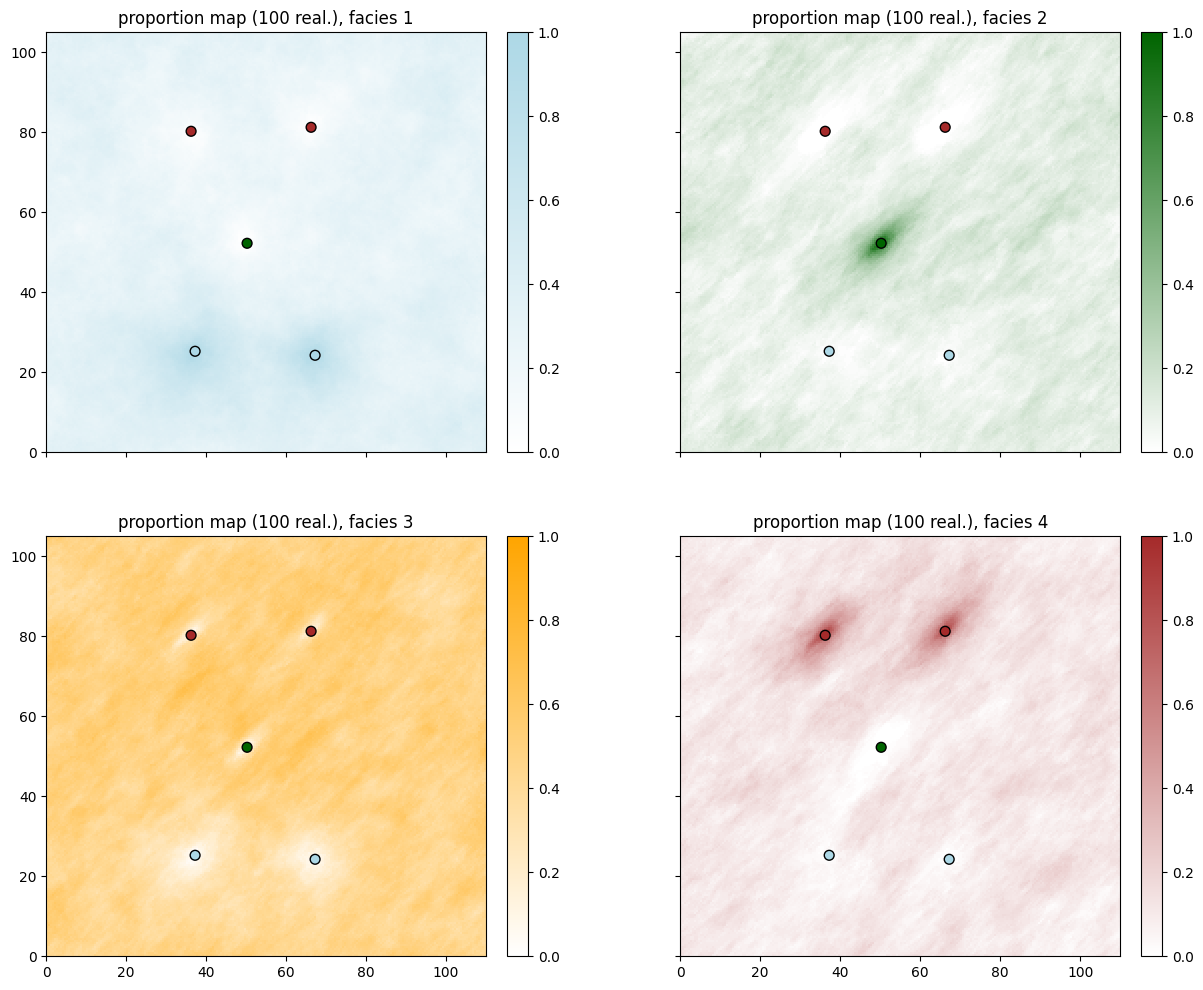

In [17]:
# Statistics (proportion map)
# ---------------------------
im_Z_stats = gn.img.imageCategProp(im_Z, categVal)

prop_col = categCol # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Plot
# ----
plt.subplots(2,2, sharex=True, sharey=True, figsize=(15,12))
plt.subplot(2,2,1)
for j in range(4):
    plt.subplot(2,2,j+1)
    gn.imgplot.drawImage2D(im_Z_stats, iv=j, cmap=cmap[j], vmin=0, vmax=1)
    if x is not None:
        plt.scatter(x[:,0], x[:,1], marker='o', s=50, color=v_col, edgecolors='black', linewidths=1)
    plt.title(f'proportion map ({im_Z.nv} real.), facies {categVal[j]}')

plt.show()

## Example : conditional 3D PGS

In [18]:
# Categories
ncat = 4
categVal = np.array([1, 2, 3, 4])

# Parameters for display (used further)
categCol = ['lightblue', 'darkgreen', 'orange', 'brown']

In [19]:
# Simulation grid (domain)
# ------------------------
nx, ny, nz = 120, 110, 55     # number of cells
sx, sy, sz = 0.5, 0.5, 1.0  # cell unit
ox, oy, oz = 0.0, 0.0, 0.0  # origin

# Covariance model for T1, T2 (latent fields)
# -------------------------------------
r_T1 = 1.0*np.array([15.0, 15.0, 15.0])
w_T1 = 1.0
nu_T1 = 1.5
cov_model_T1 = gn.covModel.CovModel3D(elem=[
    ('matern', {'w':w_T1, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T1, r) for r in r_T1]), 'nu':nu_T1}),
    ('nugget', {'w':0.01*w_T1})
    ], alpha=0.0, beta=0.0, gamma=0.0, name='cov_model_T1')

r_T2 = 1.0*np.array([30.0, 10.0, 10.0])
w_T2 = 1.0
nu_T2 = 1.5
cov_model_T2 = gn.covModel.CovModel3D(elem=[
    ('matern', {'w':w_T2, 'r':np.array([gn.covModel.cov_matern_get_r_param(nu_T2, r) for r in r_T2]), 'nu':nu_T2}),
    ], alpha=-45.0, beta=0.0, gamma=0.0, name='cov_model_T2')

# Mean of T1, T2
mean_T1 = 0.0
mean_T2 = 0.0

# Flag definition
# ---------------
def flag_value(x, y):
    v0, v1, v2, v3 = categVal
    x1 = x < -0.5
    y1 = y < -1.
    y2 = y < 1.
    return v0 * x1 + (1-x1) * (v1 * y1 + (1-y1) * (v2*y2 + v3*(1-y2)))

# Pluri-Gaussian simulation: Z = flag_value(T1, T2)
# -------------------------------------------------

# ----- Parameters -----
# Conditioning data
#x = None
#v = None
##
x = np.array([[17.25, 15.25, 15.5],
              [47.25, 14.25, 23.5],
              [31.25, 32.25, 10.5],
              [18.25, 49.25, 20.5],
              [46.25, 48.25, 40.5]])
v = np.array([1, 1, 2, 4, 4])
v_col = [categCol[np.where(vv ==categVal)[0][0]] for vv in v] # for plotting hard data (used further)
# or:
#v_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)

# Number of realizations and seed
nreal = 3
seed_sim = 13454
# ----------------------

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z, T1, T2, n_cond_ok = gn.pgs.pluriGaussianSim(
    cov_model_T1, cov_model_T2, flag_value, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz),
    x=x, v=v,
    algo_T1='fft', params_T1={'mean':mean_T1},
    algo_T2='fft', params_T2={'mean':mean_T2},# 'rangeFactorForExtensionMin':2},
    # algo_T1='classic', params_T1={'mean':mean_T1, 'nneighborMax':24}, # alternative algo for T1
    # algo_T2='classic', params_T1={'mean':mean_T2, 'nneighborMax':24}, # alternative algo for T2
    nreal=nreal,
    accept_init=0.75, accept_pow=2.0,
    mh_iter_min=100, mh_iter_max=200,
    full_output=True,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1}')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)
im_T1 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T1.shape[0], val=T1)
im_T2 = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=T2.shape[0], val=T2)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

/home/julien/anaconda3/envs/py311/lib/python3.11/site-packages/geone/covModel.py:380: RuntimeWarning: invalid value encountered in scalar power
  u1 = (0.5*u)**nu


pluriGaussianSim: simulation 1 of 3...
   ... sim 1 of 3: MH iter 1 of 100,  200...
   ... sim 1 of 3: MH iter 2 of 100,  200...
   ... sim 1 of 3: MH iter 3 of 100,  200...
   ... sim 1 of 3: MH iter 4 of 100,  200...
   ... sim 1 of 3: MH iter 5 of 100,  200...
   ... sim 1 of 3: MH iter 6 of 100,  200...
   ... sim 1 of 3: MH iter 7 of 100,  200...
   ... sim 1 of 3: MH iter 8 of 100,  200...
   ... sim 1 of 3: MH iter 9 of 100,  200...
   ... sim 1 of 3: MH iter 10 of 100,  200...
   ... sim 1 of 3: MH iter 11 of 100,  200...
   ... sim 1 of 3: MH iter 12 of 100,  200...
   ... sim 1 of 3: MH iter 13 of 100,  200...
   ... sim 1 of 3: MH iter 14 of 100,  200...
   ... sim 1 of 3: MH iter 15 of 100,  200...
   ... sim 1 of 3: MH iter 16 of 100,  200...
   ... sim 1 of 3: MH iter 17 of 100,  200...
   ... sim 1 of 3: MH iter 18 of 100,  200...
   ... sim 1 of 3: MH iter 19 of 100,  200...
   ... sim 1 of 3: MH iter 20 of 100,  200...
   ... sim 1 of 3: MH iter 21 of 100,  200...
   .

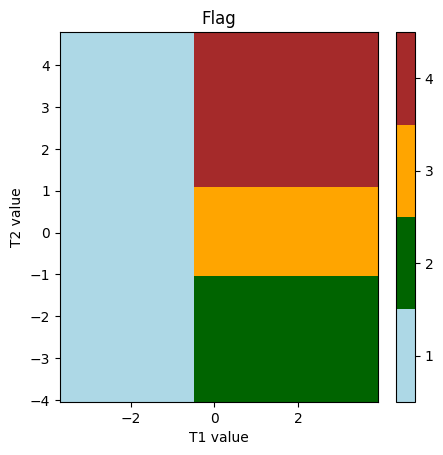

In [20]:
# Plot results 
# ------------
ireal = 0 # realization to plot

# Fill image for flag
# ------------------
fnx, fny, fnz = 50, 50, 1
fox, foy, foz = im_T1.val[ireal].min(), im_T2.val[ireal].min(), 0.0
fsx, fsy, fsz = (im_T1.val[ireal].max() - fox)/fnx, (im_T2.val[ireal].max() - foy)/fny, 1.0
fx = fox + (np.arange(fnx)+0.5)*fsx 
fy = foy + (np.arange(fny)+0.5)*fsy 
yy, xx = np.meshgrid (fy, fx, indexing='ij')
fv = flag_value(xx, yy)
im_flag = gn.img.Img(nx=fnx, ny=fny, nz=fnz, sx=fsx, sy=fsy, sz=fsz, ox=fox, oy=foy, oz=foz, nv=1, val=fv)

# Plot flag
# ---------
plt.figure()
gn.imgplot.drawImage2D(im_flag, categ=True, categVal=categVal, categCol=categCol)
plt.xlabel('T1 value')
plt.ylabel('T2 value')
plt.title(f'Flag')
plt.show()

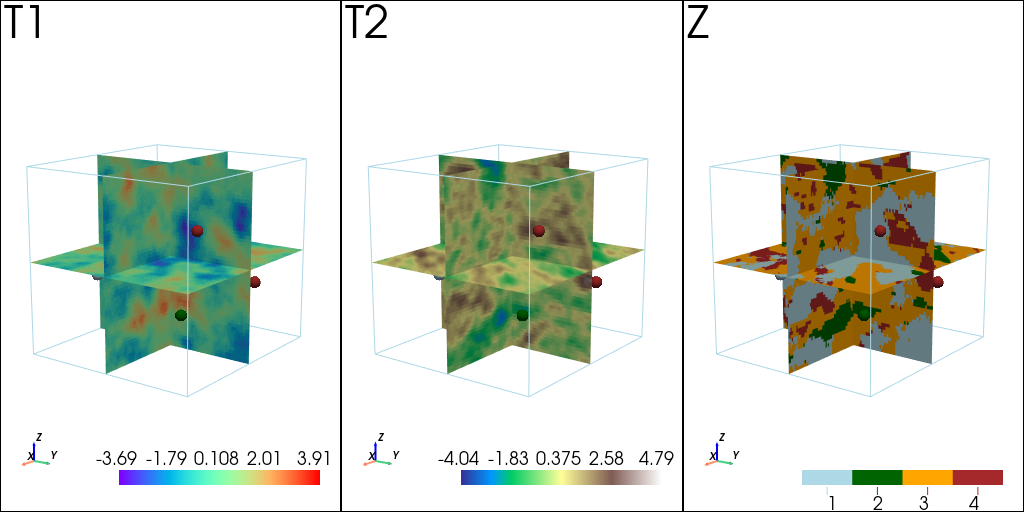

In [21]:
# Plot 3D fields
# --------------
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,3), window_size=(1024, 512), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,3), window_size=(1024, 512))

if x is not None:
    # data points to be added to 3D plot
    data_points = pv.PolyData(x)
    # ... set color for data points according to their value
    data_points_col = [matplotlib.colors.to_rgb(
        categCol[np.where(np.asarray(categVal) == i)[0][0]]) for i in v] 
        # color for data points according to their value
    # or:
    #data_points_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)

    data_points['colors'] = data_points_col

pp.subplot(0, 0)
gn.imgplot3d.drawImage3D_slice(
    im_T1, 
    plotter=pp,
    slice_normal_x=im_T1.ox+0.5*im_T1.nx*im_T1.sx,
    slice_normal_y=im_T1.oy+0.5*im_T1.ny*im_T1.sy,
    slice_normal_z=im_T1.oz+0.5*im_T1.nz*im_T1.sz,
    cmap='rainbow', #**im_T1_display,
    text='T1',
    scalar_bar_kwargs={'title':'', 'title_font_size':20, 'vertical':False})

if x is not None:
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(0, 1)
gn.imgplot3d.drawImage3D_slice(
    im_T2, 
    plotter=pp,
    slice_normal_x=im_T2.ox+0.5*im_T2.nx*im_T2.sx,
    slice_normal_y=im_T2.oy+0.5*im_T2.ny*im_T2.sy,
    slice_normal_z=im_T2.oz+0.5*im_T2.nz*im_T2.sz,
    cmap='terrain',#**im_T2_display,
    text='T2',
    scalar_bar_kwargs={'title':' ', 'title_font_size':20, 'vertical':False})

if x is not None:
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.subplot(0, 2)
gn.imgplot3d.drawImage3D_slice(
    im_Z, 
    plotter=pp,
    slice_normal_x=im_Z.ox+0.5*im_Z.nx*im_Z.sx,
    slice_normal_y=im_Z.oy+0.5*im_Z.ny*im_Z.sy,
    slice_normal_z=im_Z.oz+0.5*im_Z.nz*im_Z.sz,
    categ=True, categVal=categVal, categCol=categCol,
    text='Z',
    scalar_bar_kwargs={'title':'  ', 'title_font_size':20, 'vertical':False})

if x is not None:
    pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)
# note: distinct title for scalar bar, so that it will be displayed!

pp.link_views()

pp.show(cpos=(360, 265, 110)) # position of the camera can be specified

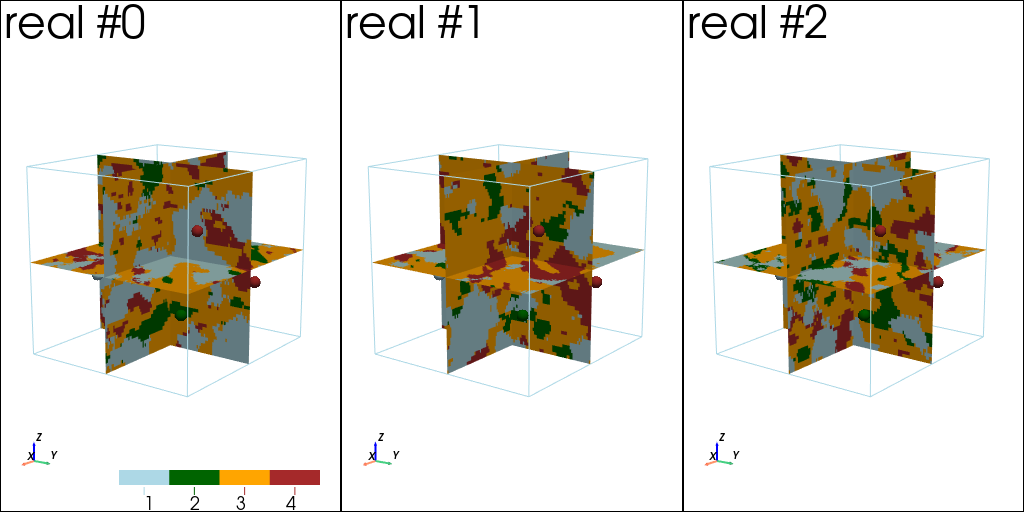

In [22]:
# Plot 3 realizations of Z
# --------------
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(1,3), window_size=(1024, 512), notebook=False)
# ... inline
pp = pv.Plotter(shape=(1,3), window_size=(1024, 512))

if x is not None:
    # data points to be added to 3D plot
    data_points = pv.PolyData(x)
    # ... set color for data points according to their value
    data_points_col = [matplotlib.colors.to_rgb(categCol[np.where(np.asarray(categVal) == i)[0][0]]) for i in v] 
        # color for data points according to their value
    # or:
    #data_points_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)
    
    data_points['colors'] = data_points_col

for i in range(3):
    pp.subplot(0, i)
    gn.imgplot3d.drawImage3D_slice(
        im_Z, iv=i,
        plotter=pp,
        slice_normal_x=im_Z.ox+0.5*im_Z.nx*im_Z.sx,
        slice_normal_y=im_Z.oy+0.5*im_Z.ny*im_Z.sy,
        slice_normal_z=im_Z.oz+0.5*im_Z.nz*im_Z.sz,
        categ=True, categVal=categVal, categCol=categCol,
        text=f'real #{i}',
        scalar_bar_kwargs={'title':'  ', 'title_font_size':20, 'vertical':False})
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(360, 265, 110)) # position of the camera can be specified

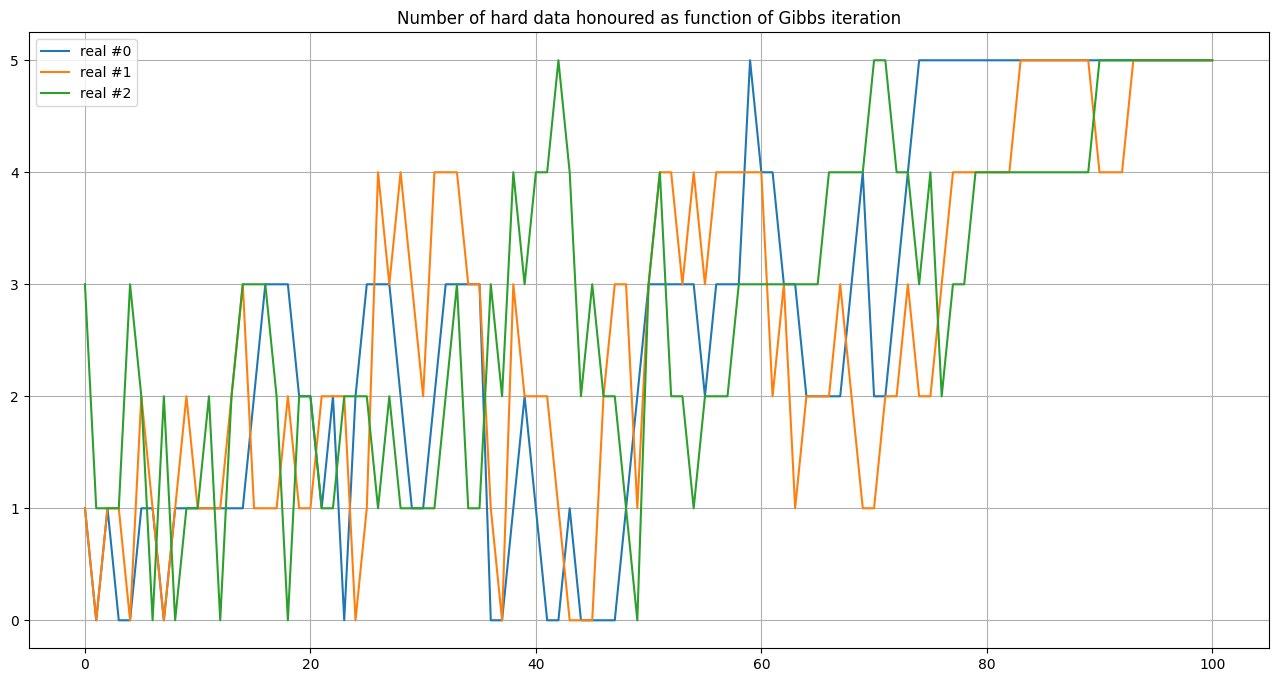

In [23]:
# Plot number of conditioning data honoured as function of iteration (Metropolis-Hasting / Gibbs sampler)
if x is not None:
    plt.figure(figsize=(16,8))
    for j in range(3):
        plt.plot(n_cond_ok[j], label=f'real #{j}')

    plt.grid()
    plt.legend()
    plt.title('Number of hard data honoured as function of Gibbs iteration')
    plt.show()

### 20 realizations (same setup)

In [24]:
# Number of realizations and seed
nreal = 20
seed_sim = 1345

# Simulation
np.random.seed(seed_sim)
t1 = time.time()
Z = gn.pgs.pluriGaussianSim(
    cov_model_T1, cov_model_T2, flag_value, (nx, ny, nz), (sx, sy, sz), (ox, oy, oz),
    x=x, v=v,
    algo_T1='fft', params_T1={'mean':mean_T1},
    algo_T2='fft', params_T2={'mean':mean_T2},# 'rangeFactorForExtensionMin':2},
    # algo_T1='classic', params_T1={'mean':mean_T1, 'nneighborMax':24}, # alternative algo for T1
    # algo_T2='classic', params_T1={'mean':mean_T2, 'nneighborMax':24}, # alternative algo for T2
    nreal=nreal,
    accept_init=0.75, accept_pow=2.0,
    mh_iter_min=100, mh_iter_max=200,
    full_output=False,
    verbose=4,
)
t2 = time.time()
print(f'Elapsed time: {t2-t1}')
print(f'Number of realizations generated: {Z.shape[0]}')

# Fill image
im_Z = gn.img.Img(nx=nx, ny=ny, nz=nz, sx=sx, sy=sy, sz=sz, ox=ox, oy=oy, oz=oz, nv=Z.shape[0], val=Z)

# Check conditioning
if x is not None and im_Z.nv > 0:
    # Get index of conditioning location in simulation grid
    x_grid_index = [gn.img.pointToGridIndex(xx[0], xx[1], xx[2], sx, sy, sz, ox, oy, oz) for xx in x]

    # Get value at hard data
    im_Z_value_at_x = np.asarray([[im_Z.val[i][grid_index[::-1]] for grid_index in x_grid_index] 
                                  for i in range(im_Z.nv)])
    conditioning_ok = np.all(im_Z_value_at_x == v)
    print('Conditioning data honoured ?', conditioning_ok)
    if not conditioning_ok:
        #print('Conditioning data, peak-to-peak diff:', np.ptp(im_Z_value_at_x - v))
        print('Conditioning data, ok at:', 100*np.mean(im_Z_value_at_x == v), '%')

pluriGaussianSim: simulation 1 of 20...
   ... sim 1 of 20: MH iter 1 of 100,  200...
   ... sim 1 of 20: MH iter 2 of 100,  200...
   ... sim 1 of 20: MH iter 3 of 100,  200...
   ... sim 1 of 20: MH iter 4 of 100,  200...
   ... sim 1 of 20: MH iter 5 of 100,  200...
   ... sim 1 of 20: MH iter 6 of 100,  200...
   ... sim 1 of 20: MH iter 7 of 100,  200...
   ... sim 1 of 20: MH iter 8 of 100,  200...
   ... sim 1 of 20: MH iter 9 of 100,  200...
   ... sim 1 of 20: MH iter 10 of 100,  200...
   ... sim 1 of 20: MH iter 11 of 100,  200...
   ... sim 1 of 20: MH iter 12 of 100,  200...
   ... sim 1 of 20: MH iter 13 of 100,  200...
   ... sim 1 of 20: MH iter 14 of 100,  200...
   ... sim 1 of 20: MH iter 15 of 100,  200...
   ... sim 1 of 20: MH iter 16 of 100,  200...
   ... sim 1 of 20: MH iter 17 of 100,  200...
   ... sim 1 of 20: MH iter 18 of 100,  200...
   ... sim 1 of 20: MH iter 19 of 100,  200...
   ... sim 1 of 20: MH iter 20 of 100,  200...
   ... sim 1 of 20: MH iter 2

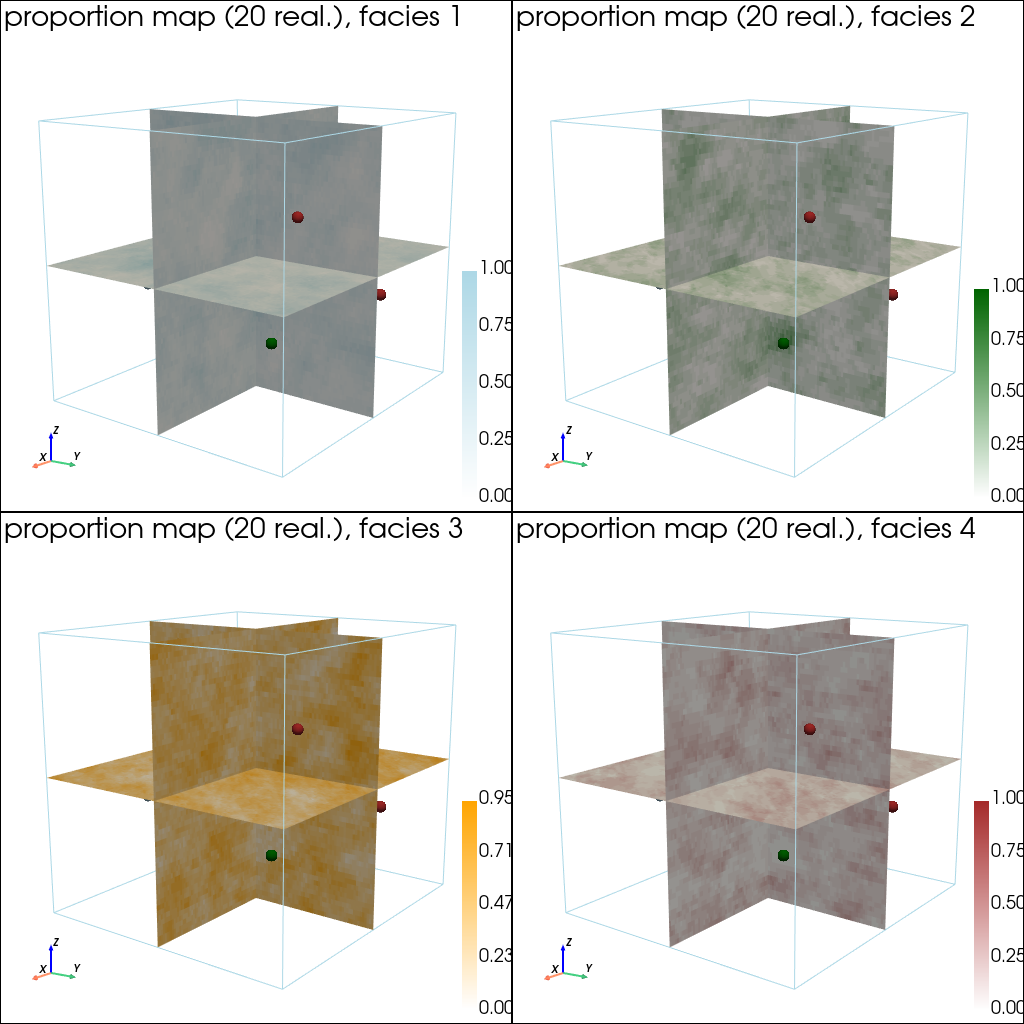

In [25]:
# Statistics (proportion map)
# ---------------------------
im_Z_stats = gn.img.imageCategProp(im_Z, categVal)

prop_col = categCol # colors for the proportion maps
cmap = [gn.customcolors.custom_cmap(['white', c]) for c in prop_col]

# Plot proportion maps
# --------------------
# Plot "interactive in pop-up window" or "inline" (comment the undesired one) ...
# ... interactive (after closing the pop-up window, the position of the camera is retrieved in output)
#pp = pv.Plotter(shape=(2,2), window_size=(1024, 512), notebook=False)
# ... inline
pp = pv.Plotter(shape=(2,2), window_size=(1024, 1024))

if x is not None:
    # data points to be added to 3D plot
    data_points = pv.PolyData(x)
    # ... set color for data points according to their value
    data_points_col = [matplotlib.colors.to_rgb(
        categCol[np.where(np.asarray(categVal) == i)[0][0]]) for i in v] 
        # color for data points according to their value
    # or:
    #data_points_col = gn.imgplot.get_colors_from_values(v.astype(float), categ=True, categVal=categVal, categCol=categCol)
    
    data_points['colors'] = data_points_col

for j in range(4):
    pp.subplot(j//2, j%2)
    gn.imgplot3d.drawImage3D_slice(
        im_Z_stats, iv=j,
        plotter=pp,
        slice_normal_x=im_Z.ox+0.5*im_Z.nx*im_Z.sx,
        slice_normal_y=im_Z.oy+0.5*im_Z.ny*im_Z.sy,
        slice_normal_z=im_Z.oz+0.5*im_Z.nz*im_Z.sz,
        cmap=cmap[j], 
        text=f'proportion map ({im_Z.nv} real.), facies {categVal[j]}',
        scalar_bar_kwargs={'title':j*' ', 'title_font_size':20, 'vertical':True})
    if x is not None:
        pp.add_mesh(data_points, rgb=True, point_size=12., render_points_as_spheres=True)

pp.link_views()

pp.show(cpos=(360, 265, 110)) # position of the camera can be specified